<a href="https://colab.research.google.com/github/hanluyt/SAH_scoring/blob/master/SAH_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0.** Explore the dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

In [ ]:
# Use cuda if we have one.
if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"

In [ ]:
df_train=pd.read_csv("https://raw.githubusercontent.com/hanluyt/SAH_scoring/master/dataset/training_set_dum.csv")
df_train.head()

24

In [ ]:
df_test=pd.read_csv("https://raw.githubusercontent.com/hanluyt/SAH_scoring/master/dataset/testing_set_dum.csv")
df_test.head()

,DSA,Gender_1,Hypertension_1,Coronary heart disease_1,Diabetes_1,Smoking_1,Pneumonia_1,Hydrocephalus_1,Location_2,Location_3,Location_4,Location_5,Location_6,Bifurcation configuration_1,Irregular shape_1,Multiple aneurysms_1,WFNS grade,Modified Fisher grade,Hunt-Hess grade,Aneurysm size,Neck size,Dome to neck ratio,Age,mRS
0,14458,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,5,3,4,3.90,2.04,1.91,65,1
1,14477,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,2,2,5.00,2.00,2.50,62,0
2,14486,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,3,2,5.42,3.24,1.67,68,0
3,14505,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,2,2,3.60,2.80,1.29,72,0
4,14527,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,4.93,3.74,1.32,39,0


In [ ]:
df_train_trimmed=df_train.drop("DSA", axis=1)
df_test_trimmed=df_test.drop("DSA", axis=1)

In [ ]:
df_train_trimmed.describe()

,Gender_1,Hypertension_1,Coronary heart disease_1,Diabetes_1,Smoking_1,Pneumonia_1,Hydrocephalus_1,Location_2,Location_3,Location_4,Location_5,Location_6,Bifurcation configuration_1,Irregular shape_1,Multiple aneurysms_1,WFNS grade,Modified Fisher grade,Hunt-Hess grade,Aneurysm size,Neck size,Dome to neck ratio,Age,mRS
count,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.00000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,0.629738,0.567541,0.051506,0.083576,0.143829,0.118562,0.071914,0.312925,0.044704,0.335277,0.130224,0.064140,0.721088,0.406220,0.206025,1.830904,2.11759,1.947522,5.064062,3.099397,1.687405,57.362488,0.173955
std,0.483110,0.495658,0.221136,0.276886,0.351087,0.323429,0.258472,0.463910,0.206753,0.472317,0.336713,0.245121,0.448682,0.491365,0.404645,1.356845,0.73726,1.062798,2.774377,1.432781,0.610770,12.037466,0.379255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,1.000000,0.800000,0.620000,0.260000,16.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.00000,1.000000,3.300000,2.100000,1.260000,49.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.00000,2.000000,4.460000,2.860000,1.530000,58.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.00000,3.000000,6.000000,3.730000,1.980000,66.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,4.00000,5.000000,23.310000,13.670000,6.140000,88.000000,1.000000


## Conclusion from part 0: 
nominal attributes: ..., ordinal attributes: ..., interval attributes: ..., ratio attributes: ...  
Implies normalization and correlation analysis.

# **1.** Preprocessing: correlation analysis & normalization

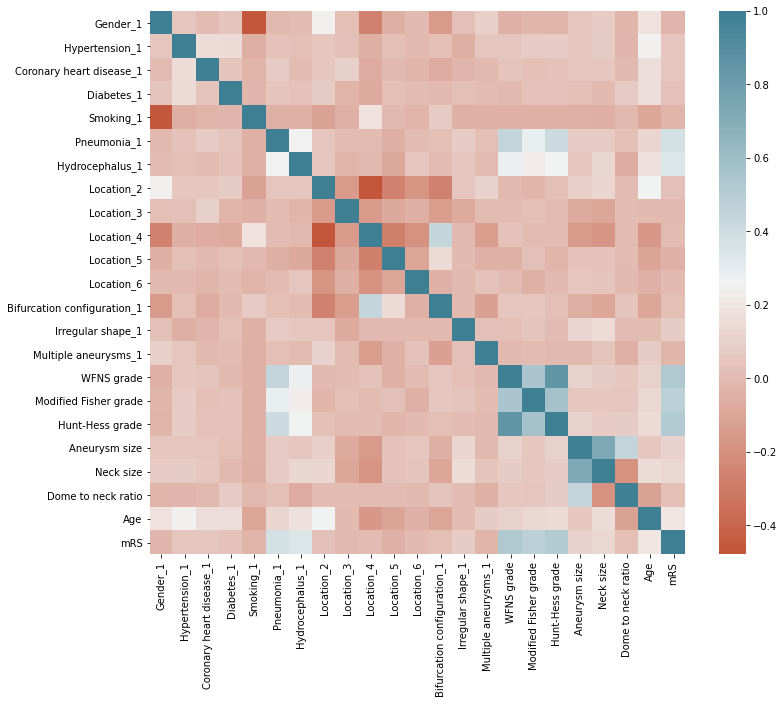

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_train_trimmed.corr(),cmap=sns.diverging_palette(20, 220, n=200))

Notice there are some strong correlations. Perform normalization to match the domain of each attribute.

In [ ]:
df_train_trimmed.corr()["mRS"]

Gender_1                      -0.014457
Hypertension_1                 0.048695
Coronary heart disease_1       0.055447
Diabetes_1                     0.037423
Smoking_1                     -0.027363
Pneumonia_1                    0.378895
Hydrocephalus_1                0.348583
Location_2                     0.027569
Location_3                    -0.012430
Location_4                     0.016212
Location_5                    -0.040449
Location_6                    -0.005034
Bifurcation configuration_1    0.016722
Irregular shape_1              0.085017
Multiple aneurysms_1          -0.024585
WFNS grade                     0.533589
Modified Fisher grade          0.476454
Hunt-Hess grade                0.512585
Aneurysm size                  0.117415
Neck size                      0.134689
Dome to neck ratio             0.016817
Age                            0.205858
mRS                            1.000000
Name: mRS, dtype: float64

Perform normalization (Compress all data into [0,1] range so no dominant attribute can shadow others)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
attr_list=["WFNS grade", "Modified Fisher grade", "Hunt-Hess grade", "Aneurysm size", "Neck size", "Dome to neck ratio", "Age"]
scaler_list=dict()
for i in attr_list:
  tmp=df_train_trimmed[i]
  scaler=MinMaxScaler()
  df_train_trimmed[i]=scaler.fit_transform(tmp.to_numpy().reshape(-1,1))
  scaler_list[i]=scaler

df_train_trimmed.describe()

,Gender_1,Hypertension_1,Coronary heart disease_1,Diabetes_1,Smoking_1,Pneumonia_1,Hydrocephalus_1,Location_2,Location_3,Location_4,Location_5,Location_6,Bifurcation configuration_1,Irregular shape_1,Multiple aneurysms_1,WFNS grade,Modified Fisher grade,Hunt-Hess grade,Aneurysm size,Neck size,Dome to neck ratio,Age,mRS
count,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,0.629738,0.567541,0.051506,0.083576,0.143829,0.118562,0.071914,0.312925,0.044704,0.335277,0.130224,0.064140,0.721088,0.406220,0.206025,0.207726,0.529397,0.236880,0.189430,0.189992,0.242756,0.574479,0.173955
std,0.483110,0.495658,0.221136,0.276886,0.351087,0.323429,0.258472,0.463910,0.206753,0.472317,0.336713,0.245121,0.448682,0.491365,0.404645,0.339211,0.184315,0.265699,0.123251,0.109792,0.103872,0.167187,0.379255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.111062,0.113410,0.170068,0.458333,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.250000,0.162594,0.171648,0.215986,0.583333,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.250000,0.500000,0.500000,0.231008,0.238314,0.292517,0.694444,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Hence we have done normalization, notice all data has been compressed into [0,1]  
Configurations of scaler are saved for future purpose.  

Perform the same normalization on test set

In [ ]:
for i in attr_list:
  tmp=df_test_trimmed[i]
  scaler=scaler_list[i]
  df_test_trimmed[i]=scaler.transform(tmp.to_numpy().reshape(-1,1))

df_test_trimmed.describe()

,Gender_1,Hypertension_1,Coronary heart disease_1,Diabetes_1,Smoking_1,Pneumonia_1,Hydrocephalus_1,Location_2,Location_3,Location_4,Location_5,Location_6,Bifurcation configuration_1,Irregular shape_1,Multiple aneurysms_1,WFNS grade,Modified Fisher grade,Hunt-Hess grade,Aneurysm size,Neck size,Dome to neck ratio,Age,mRS
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,0.648148,0.567901,0.012346,0.074074,0.086420,0.209877,0.049383,0.308642,0.061728,0.333333,0.080247,0.067901,0.592593,0.456790,0.222222,0.209877,0.515432,0.248457,0.172124,0.195738,0.218936,0.587791,0.172840
std,0.479029,0.496904,0.110766,0.262703,0.281854,0.408483,0.217338,0.463365,0.241408,0.472866,0.272517,0.252356,0.492875,0.499674,0.417029,0.350148,0.224112,0.267982,0.102625,0.117559,0.096302,0.152237,0.379281
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.013327,0.027586,0.047619,0.166667,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.108841,0.121073,0.151786,0.486111,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.250000,0.149045,0.170498,0.193027,0.583333,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.250000,0.750000,0.500000,0.212239,0.242529,0.249575,0.694444,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.630831,0.812261,0.670068,0.944444,1.000000


In [ ]:
df_train_target = df_train_trimmed["mRS"]
df_train_sample = df_train_trimmed.drop("mRS", axis=1)
train_set = torch.utils.data.dataset.TensorDataset(torch.Tensor(df_train_sample.values.astype("float64")).to(dev), torch.Tensor(df_train_target.values.astype("float64")).to(dev))

In [ ]:
df_test_target=df_test_trimmed["mRS"]
df_test_sample = df_test_trimmed.drop("mRS", axis=1)
test_set = torch.utils.data.dataset.TensorDataset(torch.Tensor(df_test_sample.values.astype("float64")).to(dev), torch.Tensor(df_test_target.values.astype("float64")).to(dev))

## Conclusion from part 1:
Data points are from different range, so normalization is performed. Moreover, notice there are some strong (~0.85) correlations.  
__Should we remove those or merge them into 1 attribute so each attribute are nearly independent to each other?__

# **2.** Pre-classification: Build classifier, 3 Layer MLP with tanh as activation function. 

Baseline model.  

hyperparameters: 
* layers = 3,  
* learning rate = 1e-4,  
* epoches = 10,  
* batchsize = 1,  
* optimizer = adam
* loss = BCEWithLogitsLoss

Flow: 22x60 -> tanh -> 60x20 -> tanh -> 20*2 -> sigmoid

In [ ]:
class MLP3(nn.Module):
  def __init__(self):
    super().__init__()

    #define layers
    self.linear1=nn.Linear(in_features=22, out_features=60)
    self.linear2=nn.Linear(in_features=60, out_features=20)
    self.linear3=nn.Linear(in_features=20, out_features=1)
    
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
    nn.init.xavier_uniform_(self.linear3.weight)

  def forward(self, t):
    t=self.linear1(t)
    t=torch.tanh(t)
    t=self.linear2(t)
    t=torch.tanh(t)
    t=self.linear3(t).view(-1,1)
    return t

In [ ]:
def get_accuracy(model,dataloader):
  count=0
  correct=0

  model.eval()
  with torch.no_grad():
    for batch in dataloader:
      samples = batch[0].to(dev)
      labels = batch[1].to(dev)
      preds=1*(model(samples)>0)
      batch_correct=preds.eq(labels).sum().item()
      batch_count=len(batch[0])
      count+=batch_count
      correct+=batch_correct
  model.train()
  return correct/count

In [ ]:
def get_confusion_matrix(model, dataset):
  model.eval()
  with torch.no_grad():
    samples = dataset.tensors[0].to(dev)
    labels = dataset.tensors[1].to(dev)
    preds = 1*(model(samples)>0)
    confusion_matrix=sklearn.metrics.confusion_matrix(labels, preds)
  model.train()
  return confusion_matrix

In [ ]:
def train_model(model, epoches, train_set, test_set, learning_rate, batch_size = 1):
  optiz = torch.optim.Adam(model.parameters(), lr=learning_rate)
  loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
  loss_func = nn.BCEWithLogitsLoss()
  
  model.train() #Set to train
  for epoch in range(epoches):
    for batch in loader:
      sample = batch[0]
      target = batch[1].view(-1,1)
      pred = model(sample)
      loss = loss_func(pred, target)

      optiz.zero_grad()
      loss.backward()
      optiz.step()
    print('Epoch {0}: train set accuracy {1}'.format(epoch,get_accuracy(model,loader)))
  
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)
  print('Epoch {0}: test set accuracy {1}'.format(epoch, get_accuracy(model, test_loader)))

In [ ]:
baseline_model = MLP3()
train_model(baseline_model, 10, train_set, test_set, learning_rate=1e-4, batch_size=1)

Epoch 0: train set accuracy 0.827016520894072
Epoch 1: train set accuracy 0.8658892128279884
Epoch 2: train set accuracy 0.8726919339164237
Epoch 3: train set accuracy 0.8765792031098154
Epoch 4: train set accuracy 0.8785228377065112
Epoch 5: train set accuracy 0.8833819241982507
Epoch 6: train set accuracy 0.8814382896015549
Epoch 7: train set accuracy 0.8843537414965986
Epoch 8: train set accuracy 0.8843537414965986
Epoch 9: train set accuracy 0.8853255587949466
Epoch 9: test set accuracy 0.8765432098765432


In [ ]:
get_confusion_matrix(baseline_model, test_set)

array([[128,   6],
       [ 14,  14]])